# Echo Sequence Problem

- 非常に単純な系列タスクを使ってVanilla LSTMの能力を確認する
- ランダムな整数の系列を入力とする、入力系列の特定の時刻の値を出力する
- 時刻はモデルへ入力せずに訓練時に固定とする
- 系列の時刻1の値を出力するモデルとすると 入力:[5, 3, 2] 出力: 3 となる

In [28]:
from random import randint
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def generate_sequence(length, n_features):
    """長さがlengthで、ランダムな整数がn_featuresまでの系列を1つ生成する"""
    return [randint(0, n_features - 1) for _ in range(length)]

- Kerasは入力も出力も one-hot encoding する必要がある
- n_featuresまでの整数値は n_features 次元の特徴量をもつ

In [10]:
def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

In [11]:
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [12]:
sequence = generate_sequence(25, 100)
print(sequence)

[5, 53, 87, 86, 41, 39, 50, 54, 51, 75, 71, 30, 79, 73, 67, 23, 30, 25, 78, 75, 58, 26, 71, 23, 69]


In [13]:
encoded = one_hot_encode(sequence, 100)
print(encoded)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
decoded = one_hot_decode(encoded)
print(decoded)

[5, 53, 87, 86, 41, 39, 50, 54, 51, 75, 71, 30, 79, 73, 67, 23, 30, 25, 78, 75, 58, 26, 71, 23, 69]


In [15]:
encoded.shape

(25, 100)

In [16]:
# samples, timesteps, features
X = encoded.reshape(1, 25, 100)
print(X.shape)

(1, 25, 100)


In [17]:
y = encoded[1, :]

In [18]:
y.shape

(100,)

- 訓練データを生成する
- KerasのLSTMへの入力は3Dテンソル: (nb_samples, timesteps, input_dim)
- KerasのLSTMの出力は2Dテンソル: (nb_samples, output_dim)

In [22]:
def generate_example(length, n_features, out_index):
    # 訓練データを1サンプル（1系列）だけ生成する
    sequence = generate_sequence(length, n_features)
    encoded = one_hot_encode(sequence, n_features)
    X = encoded.reshape((1, length, n_features))
    y = encoded[out_index].reshape(1, n_features)
    return X, y

In [23]:
X, y = generate_example(25, 100, 2)

In [24]:
X.shape, y.shape

((1, 25, 100), (1, 100))

In [25]:
X[0, 2] == y

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [29]:
# 長さ5の系列を入れて2番目の要素を出力する
length = 5
n_features = 10
out_index = 2  # echo sequence predictionで入力の何番目の要素を返すか

In [31]:
model = Sequential()
model.add(LSTM(25, input_shape=(length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25)                3600      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
Total params: 3,860
Trainable params: 3,860
Non-trainable params: 0
_________________________________________________________________


In [32]:
losses = []
accs = []
for i in range(10000):
    X, y = generate_example(length, n_features, out_index)
    history = model.fit(X, y, epochs=1, verbose=0)
    losses.append(history.history['loss'][0])
    accs.append(history.history['acc'][0])

In [33]:
len(losses), len(accs)

(10000, 10000)

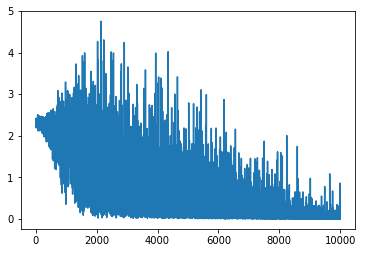

In [34]:
plt.plot(losses)

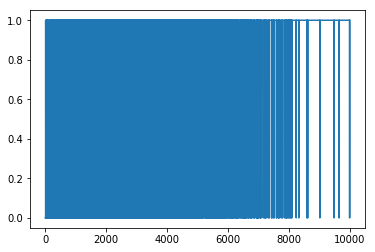

In [35]:
plt.plot(accs)

## PyTorch

In [36]:
from random import randint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')
device = torch.device('cuda' if cuda else 'cpu')

In [38]:
def generate_sequence(length, n_features):
    return np.array([randint(0, n_features - 1) for _ in range(length)])

def one_hot_encode(sequence, n_features):
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_features)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def generate_example(length, n_features, out_index):
    sequence = generate_sequence(length, n_features)
    encoded = one_hot_encode(sequence, n_features)
    
    # ndarray => tensor
    # PyTorchでは入力はfloatにする必要あり
    encoded = torch.from_numpy(encoded).float()
    
    # LSTMへの入力は3Dテンソル (seq_len, batch, input_size)
    X = encoded.view(length, 1, n_features)

    # out_index番目の入力を出力するようにする
    # PyTorchは出力はone-hotではなくラベルそのものを返す
    y = torch.Tensor([sequence[out_index]]).long()

    return X, y

In [39]:
generate_example(5, 10, 2)

(tensor([[[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]],
 
         [[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]), tensor([ 5]))

- PyTorchのLSTMはKerasと違って入力の系列の各要素に対する出力を全て出力する
- つまり、 `return_sequences = True` とした場合と同じ
- 最後の出力要素のみ使いたい場合は自分で取り出す
- 隠れ状態 (h, c) は自分で初期化して管理する
- 蓄積した勾配のリセットも自分で制御する

In [95]:
# model
length = 5
n_features = 10
hidden_size = 25
out_index = 2

class EchoSequencePredictionModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, target_size):
        super(EchoSequencePredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, target_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, h, c):
        output, (h, c) = self.lstm(input, (h, c))
        output = self.out(output)
        output = self.softmax(output)
        return output, (h, c)

    def init_hidden(self):
        # (num_layers, batch, hidden_size)
        h = torch.zeros(1, 1, self.hidden_size).to(device)
        c = torch.zeros(1, 1, self.hidden_size).to(device)
        return h, c

In [96]:
model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)

In [97]:
model

EchoSequencePredictionModel(
  (lstm): LSTM(10, 25)
  (out): Linear(in_features=25, out_features=10, bias=True)
  (softmax): LogSoftmax()
)

- モデルにsoftmax()という活性化関数を付けているので交差エントロピー誤差にする場合はNLLoss()を指定する

In [98]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

# training
for i in range(10000):
    # 系列データを1つ生成
    X, y = generate_example(length, n_features, out_index)

    # 系列を1つ入力してパラメータ更新したら勾配はリセット
    model.zero_grad()
    
    # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
    # LSTMのパラメータは更新されたまま残る
    h0, c0 = model.init_hidden()

    # 系列を入力して出力系列を求める
    # output: (seq_len, batch, hidden_size)
    output, (h, c) = model(X, h0, c0)

    # many-to-oneのタスクなので出力系列の最後の要素のみ使う
    loss = criterion(output[-1], y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

In [99]:
len(losses)

10000

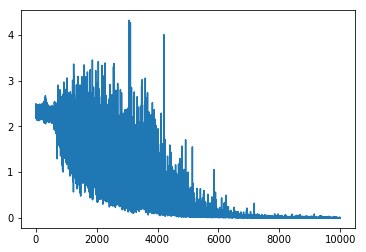

In [100]:
plt.plot(losses)

### 予測

In [88]:
X, y = generate_example(length, n_features, out_index)
h0, c0 = model.init_hidden()
yhat = model(X, h0, c0)

In [89]:
print(yhat[0].size())     # output
print(yhat[1][0].size())  # h
print(yhat[1][1].size())  # c

torch.Size([5, 1, 10])
torch.Size([1, 1, 25])
torch.Size([1, 1, 25])


In [90]:
print('input sequence:', [one_hot_decode(x) for x in X])
print('expected:', y)
print('predicted:', torch.argmax(yhat[0][-1]))

input sequence: [[tensor(5)], [tensor(0)], [tensor(4)], [tensor(8)], [tensor(7)]]
expected: tensor([ 4])
predicted: tensor(4)


## 実験

In [159]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

- 入力系列が長くなると？
- 入力系列が長くなると予測が難しくなる傾向がある
- 8と9が逆だったらよかった？

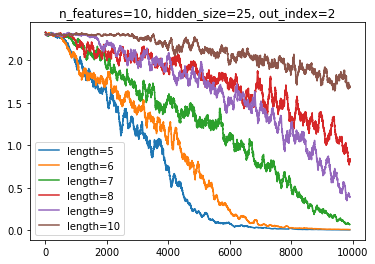

In [163]:
# model
n_features = 10
hidden_size = 25
out_index = 2

for length in range(5, 11):
    model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    # training
    for i in range(10000):
        # 系列データを1つ生成
        X, y = generate_example(length, n_features, out_index)

        # 系列を1つ入力してパラメータ更新したら勾配はリセット
        model.zero_grad()

        # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
        # LSTMのパラメータは更新されたまま残る
        h0, c0 = model.init_hidden()

        # 系列を入力して出力系列を求める
        # output: (seq_len, batch, hidden_size)
        output, (h, c) = model(X, h0, c0)

        # many-to-oneのタスクなので出力系列の最後の要素のみ使う
        loss = criterion(output[-1], y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    losses = moving_average(losses, 100)
    plt.title('n_features=%d, hidden_size=%d, out_index=%d' % (n_features, hidden_size, out_index))
    plt.plot(losses, label='length=%d' % length)
    plt.legend()

- 予測の場所が最後の位置より遠い方が予測が難しくなる？
- あまりそのような傾向はなさそう
- もっと長くすると傾向でるか？

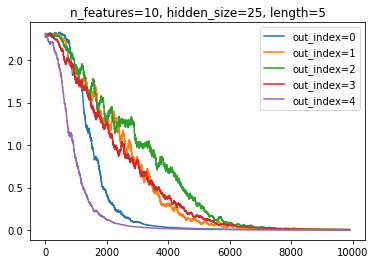

In [165]:
# model
length = 5
n_features = 10
hidden_size = 25

for out_index in range(0, length):
    model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    # training
    for i in range(10000):
        # 系列データを1つ生成
        X, y = generate_example(length, n_features, out_index)

        # 系列を1つ入力してパラメータ更新したら勾配はリセット
        model.zero_grad()

        # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
        # LSTMのパラメータは更新されたまま残る
        h0, c0 = model.init_hidden()

        # 系列を入力して出力系列を求める
        # output: (seq_len, batch, hidden_size)
        output, (h, c) = model(X, h0, c0)

        # many-to-oneのタスクなので出力系列の最後の要素のみ使う
        loss = criterion(output[-1], y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    losses = moving_average(losses, 100)
    plt.title('n_features=%d, hidden_size=%d, length=%d' % (n_features, hidden_size, length))
    plt.plot(losses, label='out_index=%d' % out_index)
    plt.legend()

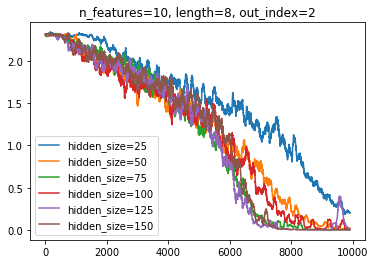

In [167]:
# model
length = 8
n_features = 10
hidden_size = 25
out_index = 2

for hidden_size in range(25, 151, 25):
    model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    # training
    for i in range(10000):
        # 系列データを1つ生成
        X, y = generate_example(length, n_features, out_index)

        # 系列を1つ入力してパラメータ更新したら勾配はリセット
        model.zero_grad()

        # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
        # LSTMのパラメータは更新されたまま残る
        h0, c0 = model.init_hidden()

        # 系列を入力して出力系列を求める
        # output: (seq_len, batch, hidden_size)
        output, (h, c) = model(X, h0, c0)

        # many-to-oneのタスクなので出力系列の最後の要素のみ使う
        loss = criterion(output[-1], y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    losses = moving_average(losses, 100)
    plt.title('n_features=%d, length=%d, out_index=%d' % (n_features, length, out_index))
    plt.plot(losses, label='hidden_size=%d' % hidden_size)
    plt.legend()

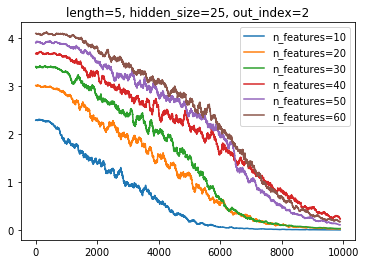

In [168]:
# model
length = 5
hidden_size = 25
out_index = 2

for n_features in range(10, 61, 10):
    model = EchoSequencePredictionModel(n_features, hidden_size, n_features).to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    # training
    for i in range(10000):
        # 系列データを1つ生成
        X, y = generate_example(length, n_features, out_index)

        # 系列を1つ入力してパラメータ更新したら勾配はリセット
        model.zero_grad()

        # 新しい系列を入力するたびに隠れ状態（hとc）はリセット
        # LSTMのパラメータは更新されたまま残る
        h0, c0 = model.init_hidden()

        # 系列を入力して出力系列を求める
        # output: (seq_len, batch, hidden_size)
        output, (h, c) = model(X, h0, c0)

        # many-to-oneのタスクなので出力系列の最後の要素のみ使う
        loss = criterion(output[-1], y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    losses = moving_average(losses, 100)
    plt.title('length=%d, hidden_size=%d, out_index=%d' % (length, hidden_size, out_index))
    plt.plot(losses, label='n_features=%d' % n_features)
    plt.legend()